# Part II - Ford GoBike Trip Duration per Datetime and User Type
## by Ebele-Muolokwu Nonso


## Investigation Overview


In this investigation, I will to take a look at the relationship between the duration of trips changes and to DateTime and customer type. The main focus was on hours of the day, days of the week and customer type.


## Dataset Overview

The information relates to over 183,000 trips taken in a bike-sharing program that serves the larger San Francisco Bay area. In addition to other variables like the member's year of birth, start and finish station names, start and end station longitude and latitude, start and end station unique id, and others, the data characteristics include duration (secs) and others like DateTime, customer type, and gender. A total of 8000 data points were dropped from the study because of errors or missing data.

In [1]:
!pip install geopy

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
pd.set_option('display.max_columns', 200)
# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe
bike =pd.read_csv('tripdata.csv')

In [4]:
#Data preprocessing to extract the needed data
bike.dropna(inplace=True)

bike['start_time'] = pd.to_datetime(bike['start_time'])
bike['end_time'] = pd.to_datetime(bike['end_time'])

bike['bike_id'] =bike.bike_id.astype(str)


import datetime as dt
bike['start_day'] = bike['start_time'].dt.day_name()
bike['start_month'] = bike['start_time'].dt.month_name()
bike['start_hr'] = bike['start_time'].dt.hour
bike['start_hr'] = bike.start_hr.astype(str)

bike.member_birth_year = pd.to_datetime(bike.member_birth_year.astype(str).str[:-2].replace('n', np.nan))
bike['age'] = bike.start_time.dt.year - bike.member_birth_year.dt.year


bike['end_day'] = bike['end_time'].dt.day_name()
bike['end_month'] = bike['end_time'].dt.month_name()
bike['end_hr'] = bike['end_time'].dt.hour
bike['end_hr'] = bike.end_hr.astype(str)
bike['age_bin'] = pd.cut(x=bike['age'], bins=[1, 35, 60, 141], labels=['Young','Middle_aged', 'Old'])


In [5]:
from geopy.distance import great_circle as GRC

bike['avg_distance'] = bike[['start_station_latitude','start_station_longitude', 'end_station_latitude', 'end_station_longitude']].apply(lambda x: GRC((x.start_station_latitude,x.start_station_longitude),
                                          (x.end_station_latitude,x.end_station_longitude)).km, axis=1)

In [6]:
ordinal_var_list = [['end_hr', [str(x) for x in range(0,24)]],
                    ['end_day', ['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday', 'Sunday']],
                   ['start_hr',[str(x) for x in range(0,24)]],
                   ['start_day', ['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday', 'Sunday']]]

for var, order in ordinal_var_list:
    order_variable = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = order)
    bike[var] = bike[var].astype(order_variable)

## Distribution of Rides by Days
What is the distribution of number of rides take across the seven days?
The plot below illustrates the amount of rides for each day of the week over the period covered in the dataset

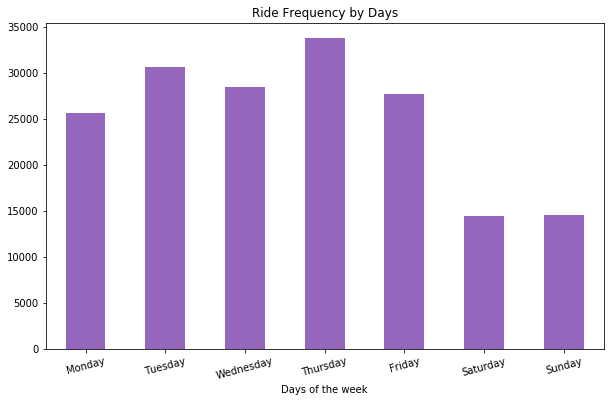

In [7]:

default_color = sb.color_palette()[0]
fig, ax = plt.subplots(1, figsize = [10,6])
bike.groupby('start_day')['end_hr'].count().reset_index().set_index('start_day')\
                                            .plot(kind='bar', ax = ax, color=sb.color_palette()[4], legend=None)

plt.xlabel('Days of the week')
plt.title('Ride Frequency by Days')
plt.xticks(rotation= 15);

## Observations
- Most rides were taken on Thursdays then Tuesdays.
- Weekends have the lowest trip records.

## Distribution of Rides by Hours
The plot below illustrates the number of rides taken over the 24 hours span in the dataset. It shows the peak time when bikes are rented.


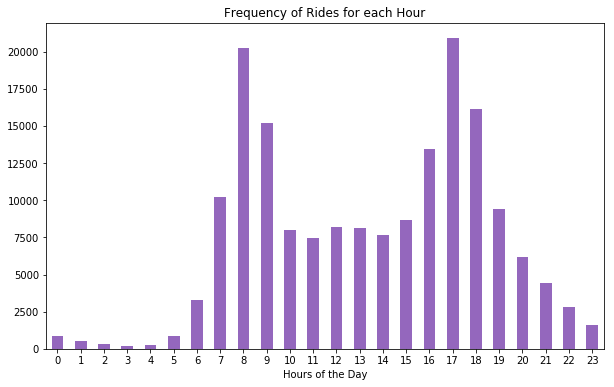

In [8]:
fig, ax = plt.subplots(figsize = [10,6])
bike.groupby('start_hr')['end_hr'].count().reset_index().set_index('start_hr').plot(kind='bar', ax = ax, legend=None,
                                                                                 color = sb.color_palette()[4]);
plt.xlabel('Hours of the Day')
plt.xticks(rotation= 0)
plt.title('Frequency of Rides for each Hour');

## Observations
- There are two peaks, one at 8am and another at 5pm. This could be as a result of people leaving for work and coming back from work
- The lowest count is observed from 10pm - 5am

## Distribution of Distance by users
This visualization shows the the distribution of the distance travelled by different riders

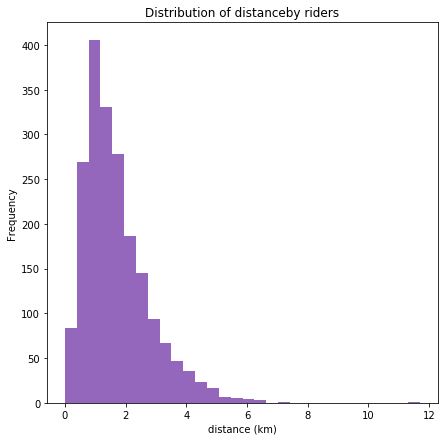

In [9]:
bike.avg_distance = bike.avg_distance.round(3)
plt.figure(figsize=(7,7))
bike.sample(2000).avg_distance.plot(kind='hist', bins= 30, title='Distribution of distanceby riders',  color = sb.color_palette()[4] )
plt.xlabel('distance (km)');

## Observations
The plot is skewed to the right with a very long tail, The mean distance is 1km. It skews towards the right with some outliers around 9km

## Violin Plot of Gender against Average Distance and Duration
This plots shows the the distribution of time and distance against the different genders


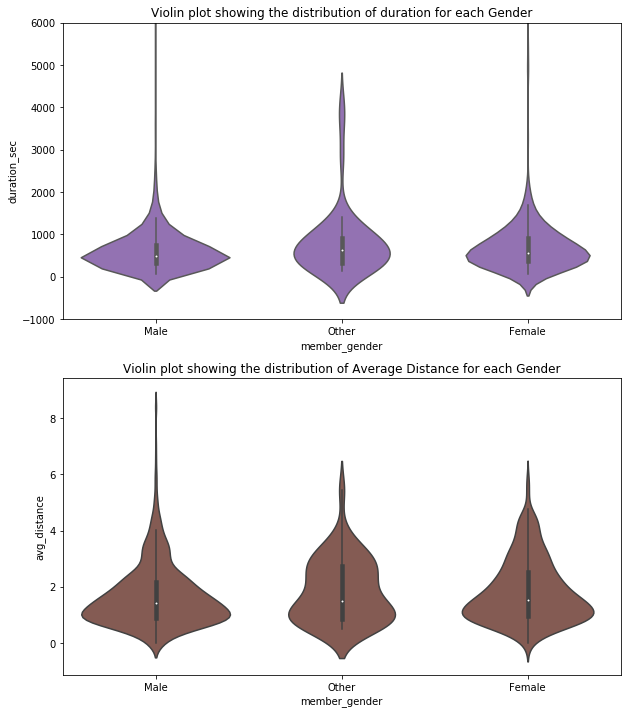

In [10]:

df_sample = bike.sample(2000)
fig,ax = plt.subplots(2, figsize=(10,12))


sb.violinplot(data=df_sample, x='member_gender', y='duration_sec', color =sb.color_palette()[4], ax=ax[0])
sb.violinplot(data=df_sample, x='member_gender', y='avg_distance', color =sb.color_palette()[5], ax=ax[1])
ax[0].title.set_text('Violin plot showing the distribution of duration for each Gender')
ax[1].title.set_text('Violin plot showing the distribution of Average Distance for each Gender')
ax[0].set_ylim([-1000, 6000])
plt.show()





## Observations
- Customers spend more time on a trip in comparism to subscriber
- The average time spent is almost equal amongst male, female, other
- There are negative entries in the dataset that need to be seen


## Trip Duration across Different Days in the week
This plot displays the average time taken for trips across the different days in the week


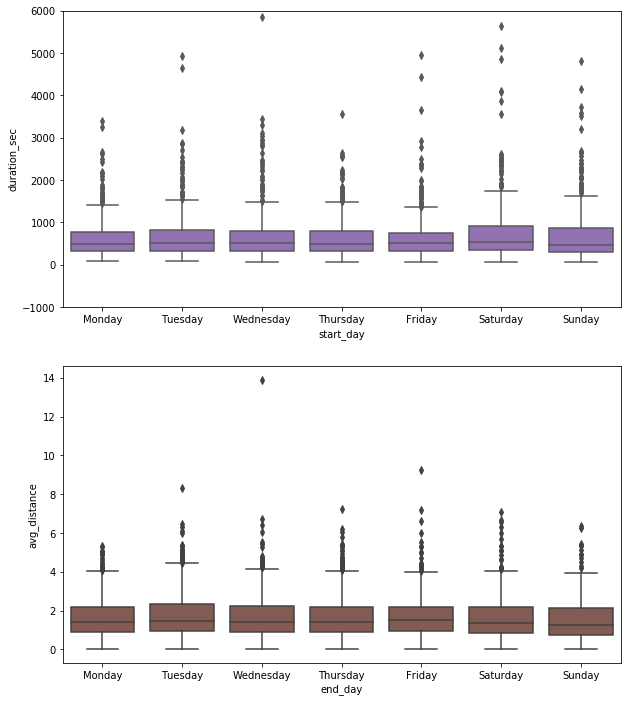

In [11]:
df_sample = bike.sample(5000)
fig,ax = plt.subplots(2, figsize=(10,12))



sb.boxplot(data=df_sample, x='start_day', y='duration_sec', color =sb.color_palette()[4], ax=ax[0])
sb.boxplot(data=df_sample, x='end_day', y='avg_distance', color =sb.color_palette()[5], ax=ax[1])

ax[0].set_ylim([-1000, 6000])
plt.show()

## Observations
- The average time spent over all week days are nearly the same
- Thursday and Wednesday has the least amount of outliers
- The average distance travelled is almost the same for all days, the minimum being on Wednesday

## Correlation between Trip Duration, Trip Distance and User Type?
This plot show the correlation between ride distance,time and user_type

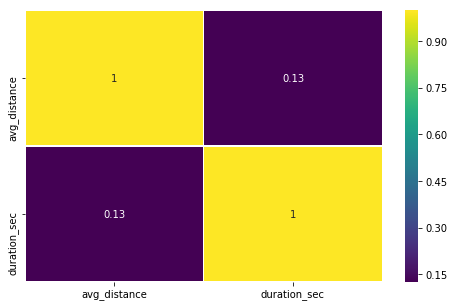

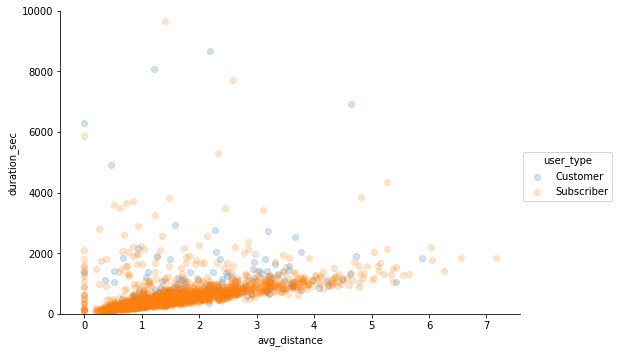

In [12]:
fig,ax = plt.subplots(1, figsize=(8,5))

df_sam = bike.sample(2000)
sb.heatmap(df_sam[['avg_distance', 'duration_sec']].corr(),ax=ax,cmap='viridis',linewidths=0.30,annot=True)
sb.lmplot(x='avg_distance', y='duration_sec', data = df_sam, fit_reg=False,
          hue='user_type',scatter_kws={"alpha":0.2,}, size=5, aspect=1.5)
plt.ylim(0, 10000);
plt.show()

## Observations 
## Observations
- There is a linear correlation between speed and distance
- Tere is no clear demarcation between the user types 
- The correlation Plot is low because of the excess outliers from the dataset
- The average distance and average time has a positive relationship (Correlation)

### Generate Slideshow
Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show.  

In [ ]:
# Use this command if you are running this file in local
!jupyter nbconvert Ford_GoBike_System_Data_Part_2.ipynb --to slides --post serve --no-input --no-prompt


[NbConvertApp] Converting notebook Ford_GoBike_System_Data_Part_2.ipynb to slides
[NbConvertApp] Writing 287716 bytes to Ford_GoBike_System_Data_Part_2.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Ford_GoBike_System_Data_Part_2.slides.html
Use Control-C to stop this server
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: x-www-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: firefox: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: iceweasel: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: seamonkey: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: mozilla: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: epiphany: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: konqueror: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: chromium-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: google-chrome: not found
/usr/bin/xdg-open: 778: 

> In the classroom workspace, the generated HTML slideshow will be placed in the home folder. 

> In local machines, the command above should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation! At last, you can stop the Kernel. 